# Discussion Assignment 03 

### Date: 5th Nov 2020
#### Sherry

The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [2]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [ ]:
help(BinaryClassificationPerformance)

## Data cleaning and pruning - not incorporated yet

In [91]:
# exploring the dataset - not used in model-building
train_dataset = pd.read_csv('../../data/toxiccomments_train.csv')


In [103]:
train_dataset[train_dataset.comment_text == 'Sorry Monkey the page got locked while we figure out who you are and report you to your employer.  YOU got pwned!   User:DONNY PWNED YOU']

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
90865,f3175595f7f157e3,Sorry Monkey the page got locked while we figu...,0,0,0,0,0,0


# Function for feature building and extraction on natural language data

#### Changes made to feature building and extraction:
  1. **added bigrams**
  
        `hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, ngram_range=(1,2))`
        
        
  2. **added smooth_idf parameter as False**
  
        `TfidfTransformer(smooth_idf=False)`
        
        
  3. **Added two features: question counts and exclamation counts**
            `toxic_data['exclaim_count'] = toxic_data['comment_text'].str.count("\!")`
            `toxic_data['quest_count'] = toxic_data['comment_text'].str.count("\?")`
       

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
#         hv = HashingVectorizer(n_features=2 ** 13, alternate_sign=False, strip_accents = 'ascii', ngram_range=(3,5), stop_words='english', analyzer = 'word')
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, ngram_range=(1,2))
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer(smooth_idf=False)
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['exclaim_count'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['quest_count'] = toxic_data['comment_text'].str.count("\?")

    
#     toxic_data['allcaps_count'] = toxic_data['comment_text'].str.findall(r'[A-Z]').str.len()

#     X_quant_features = toxic_data[["word_count", "exclaim_count", "allcaps_count"]]
    X_quant_features = toxic_data[["word_count", "exclaim_count", "quest_count"]]
#     X_quant_features = toxic_data[["word_count", "exclaim_count"]]


    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../../data/toxiccomments_train.csv', my_random_seed=1999)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: SVM-C

### SVM-C c-value/margin = 0.9; 1.1; 1.3; 0.8; 0.7; 0.5; 4
Cfloat, default=1.0

    Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive.


In [55]:
from sklearn.svm import LinearSVC
svmc_09 = LinearSVC(loss='hinge', C=0.9)
svmc_09.fit(X_train, y_train)

svmc_09_performance_train = BinaryClassificationPerformance(svmc_09.predict(X_train), y_train, 'svmc_09_train')
svmc_09_performance_train.compute_measures()
print(svmc_09_performance_train.performance_measures)

/Users/smanzar/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


{'Pos': 12971, 'Neg': 114685, 'TP': 12960, 'TN': 114658, 'FP': 27, 'FN': 11, 'Accuracy': 0.9997023249984333, 'Precision': 0.997920997920998, 'Recall': 0.9991519543597256, 'desc': 'svmc_09_train'}


In [56]:
from sklearn.svm import LinearSVC
svmc_11 = LinearSVC(loss='hinge', C=1.1)
svmc_11.fit(X_train, y_train)

svmc_11_performance_train = BinaryClassificationPerformance(svmc_11.predict(X_train), y_train, 'svmc_11_train')
svmc_11_performance_train.compute_measures()
print(svmc_11_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12954, 'TN': 114662, 'FP': 23, 'FN': 17, 'Accuracy': 0.9996866578930876, 'Precision': 0.9982276335054326, 'Recall': 0.9986893840104849, 'desc': 'svmc_11_train'}


In [57]:
from sklearn.svm import LinearSVC
svmc_13 = LinearSVC(loss='hinge', C=1.3)
svmc_13.fit(X_train, y_train)

svmc_13_performance_train = BinaryClassificationPerformance(svmc_13.predict(X_train), y_train, 'svmc_13_train')
svmc_13_performance_train.compute_measures()
print(svmc_13_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12958, 'TN': 114658, 'FP': 27, 'FN': 13, 'Accuracy': 0.9996866578930876, 'Precision': 0.9979206777050443, 'Recall': 0.998997764243312, 'desc': 'svmc_13_train'}


In [58]:
from sklearn.svm import LinearSVC
svmc_08 = LinearSVC(loss='hinge', C=0.8)
svmc_08.fit(X_train, y_train)

svmc_08_performance_train = BinaryClassificationPerformance(svmc_08.predict(X_train), y_train, 'svmc_08_train')
svmc_08_performance_train.compute_measures()
print(svmc_08_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12957, 'TN': 114660, 'FP': 25, 'FN': 14, 'Accuracy': 0.9996944914457605, 'Precision': 0.9980742566630719, 'Recall': 0.9989206691851052, 'desc': 'svmc_08_train'}


In [59]:
from sklearn.svm import LinearSVC
svmc_07 = LinearSVC(loss='hinge', C=0.7)
svmc_07.fit(X_train, y_train)

svmc_07_performance_train = BinaryClassificationPerformance(svmc_07.predict(X_train), y_train, 'svmc_07_train')
svmc_07_performance_train.compute_measures()
print(svmc_07_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12953, 'TN': 114664, 'FP': 21, 'FN': 18, 'Accuracy': 0.9996944914457605, 'Precision': 0.9983813781408972, 'Recall': 0.9986122889522782, 'desc': 'svmc_07_train'}


In [60]:
from sklearn.svm import LinearSVC
svmc_05 = LinearSVC(loss='hinge', C=0.5)
svmc_05.fit(X_train, y_train)

svmc_05_performance_train = BinaryClassificationPerformance(svmc_05.predict(X_train), y_train, 'svmc_05_train')
svmc_05_performance_train.compute_measures()
print(svmc_05_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12957, 'TN': 114658, 'FP': 27, 'FN': 14, 'Accuracy': 0.9996788243404149, 'Precision': 0.9979205175600739, 'Recall': 0.9989206691851052, 'desc': 'svmc_05_train'}


In [61]:
from sklearn.svm import LinearSVC
svmc_4 = LinearSVC(loss='hinge', C=4)
svmc_4.fit(X_train, y_train)

svmc_4_performance_train = BinaryClassificationPerformance(svmc_4.predict(X_train), y_train, 'svmc_4_train')
svmc_4_performance_train.compute_measures()
print(svmc_4_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12956, 'TN': 114658, 'FP': 27, 'FN': 15, 'Accuracy': 0.999670990787742, 'Precision': 0.9979203573904336, 'Recall': 0.9988435741268985, 'desc': 'svmc_4_train'}


### ROC plot to compare performance of various models and fits

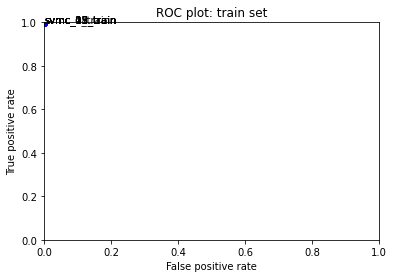

In [62]:
# fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
# fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]
# fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_800_performance_train, rdg_50000_performance_train]
fits_svmc = [svmc_09_performance_train, svmc_11_performance_train, svmc_13_performance_train, svmc_08_performance_train, svmc_07_performance_train, svmc_05_performance_train, svmc_4_performance_train]


# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
# plt.axis([0, 1, 0, 1])
# plt.title('ROC plot: train set')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.show()

for fit in fits_svmc:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: SVM-C

### SVM-C c-value/margin = 10


In [63]:
svmc_09_performance_test = BinaryClassificationPerformance(svmc_09.predict(X_test), y_test, 'svmc_09_test')
svmc_09_performance_test.compute_measures()
print(svmc_09_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2079, 'TN': 25828, 'FP': 2833, 'FN': 1175, 'Accuracy': 0.874416418611938, 'Precision': 0.42324918566775244, 'Recall': 0.6389059618930547, 'desc': 'svmc_09_test'}


In [64]:
svmc_11_performance_test = BinaryClassificationPerformance(svmc_11.predict(X_test), y_test, 'svmc_11_test')
svmc_11_performance_test.compute_measures()
print(svmc_11_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2075, 'TN': 25850, 'FP': 2811, 'FN': 1179, 'Accuracy': 0.8749804167319443, 'Precision': 0.42468276708964386, 'Recall': 0.6376767055931162, 'desc': 'svmc_11_test'}


In [65]:
svmc_13_performance_test = BinaryClassificationPerformance(svmc_13.predict(X_test), y_test, 'svmc_13_test')
svmc_13_performance_test.compute_measures()
print(svmc_13_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2076, 'TN': 25848, 'FP': 2813, 'FN': 1178, 'Accuracy': 0.874949083503055, 'Precision': 0.4246267130292493, 'Recall': 0.6379840196681008, 'desc': 'svmc_13_test'}


In [66]:
svmc_08_performance_test = BinaryClassificationPerformance(svmc_08.predict(X_test), y_test, 'svmc_08_test')
svmc_08_performance_test.compute_measures()
print(svmc_08_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2077, 'TN': 25832, 'FP': 2829, 'FN': 1177, 'Accuracy': 0.8744790850697164, 'Precision': 0.4233591520587036, 'Recall': 0.6382913337430854, 'desc': 'svmc_08_test'}


In [67]:
svmc_07_performance_test = BinaryClassificationPerformance(svmc_07.predict(X_test), y_test, 'svmc_07_test')
svmc_07_performance_test.compute_measures()
print(svmc_07_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2077, 'TN': 25845, 'FP': 2816, 'FN': 1177, 'Accuracy': 0.8748864170452765, 'Precision': 0.42448395667279787, 'Recall': 0.6382913337430854, 'desc': 'svmc_07_test'}


In [68]:
svmc_05_performance_test = BinaryClassificationPerformance(svmc_05.predict(X_test), y_test, 'svmc_05_test')
svmc_05_performance_test.compute_measures()
print(svmc_05_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2080, 'TN': 25848, 'FP': 2813, 'FN': 1174, 'Accuracy': 0.8750744164186119, 'Precision': 0.42509707745759245, 'Recall': 0.6392132759680393, 'desc': 'svmc_05_test'}


In [69]:
svmc_4_performance_test = BinaryClassificationPerformance(svmc_4.predict(X_test), y_test, 'svmc_4_test')
svmc_4_performance_test.compute_measures()
print(svmc_4_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2080, 'TN': 25827, 'FP': 2834, 'FN': 1174, 'Accuracy': 0.874416418611938, 'Precision': 0.42328042328042326, 'Recall': 0.6392132759680393, 'desc': 'svmc_4_test'}


### ROC plot to compare performance of various models and fits

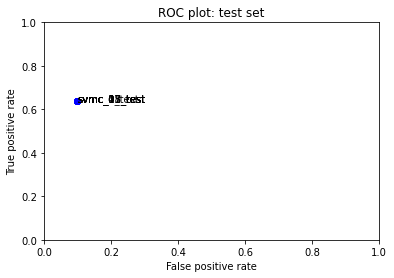

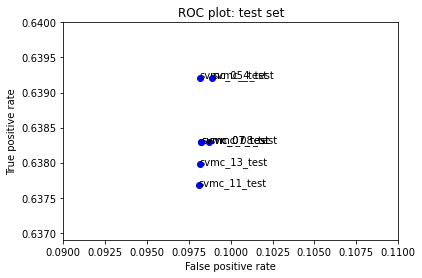

In [78]:
# fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
# fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]
# fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]
# fits = [svmc_10_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_800_performance_test, rdg_50000_performance_test]


# for fit in fits:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
# plt.axis([0, 1, 0, 1])
# plt.title('ROC plot: test set')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.show()

# fits_small = [svmc_10_performance_test, svm_performance_test, rdg_800_performance_test, rdg_50000_performance_test]


# for fit in fits_small:
#     plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
#     plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
#              fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
# plt.axis([0, 1, 0, 1])
# plt.title('ROC plot: test set')
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.show()

fits_svmc = [svmc_07_performance_test, svmc_11_performance_test, svmc_13_performance_test, svmc_08_performance_test, svmc_07_performance_test, svmc_05_performance_test, svmc_4_performance_test]
for fit in fits_svmc:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

for fit in fits_svmc:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0.09, 0.11, 0.6369, 0.64])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
